In [1]:
import Environment
import Shop
from mab.ts_learner import *
from mab.ucb_learner import *
from utilities import *

In [2]:
shop_ts = Shop.Shop()
shop_ucb = Shop.Shop()

shop_ts_normalized = Shop.Shop()


shop_clairvoyant = Shop.Shop()

env = Environment.Environment(shop_clairvoyant.prices1,shop_clairvoyant.prices2,shop_clairvoyant.discounts)

# The environment decides the conversion rates, which are shared among all the shops.
shop_clairvoyant.set_conv_rate(env.true_conv1, env.true_conv2)
shop_ts.set_conv_rate(env.true_conv1,env.true_conv2)
shop_ucb.set_conv_rate(env.true_conv1, env.true_conv2)

#Initialize learners
n_arms = len(env.prices1)
shop_ts.set_price_learner('TS', n_arms)
shop_ucb.set_price_learner('UCB', n_arms)

In [3]:
# we have fixed promo fractions
promo_fractions = np.array([[0.3, 0.2, 0.25, 0.25],     # every row is a customer class
                            [0.2, 0.25, 0.30, 0.25],     # every column is a promo type   
                            [0.1, 0.2, 0.3, 0.4],
                            [0.15, 0.15, 0.45, 0.25]])
                            
# we have a fixed price for item 2
price2_index = 2
price2 = env.prices2[price2_index]
conv2 = shop_ts.conv2[:,:,price2_index] # rows -> promo, columns -> customer class
max_ind_reward = price2 + max(env.prices1)

In [4]:
#### get clairvoyant price
expected_rewards = np.array([0.0, 0.0, 0.0, 0.0, 0.0])
customers_mean = np.array([25, 25, 25, 25])

for i in range(len(env.prices1)):
    for j in range(env.n_classes):
        expected_reward_from_class = customers_mean[j]*env.prices1[i]*env.true_conv1[j, i]
        #print("Expected reward from item 1 for price-class", i, "-", j, "----->", expected_reward_from_class)
        for k in range(len(env.discounts)):
            expected_reward_from_class += promo_fractions[j,k]*customers_mean[j]*env.true_conv1[j, i]*price2*env.true_conv2[k, j, price2_index]*(1 - env.discounts[k])
        expected_rewards[i] += expected_reward_from_class

        #print("Expected Reward for Price", i, "from class", j, "--->", expected_reward_from_class)
        #print("************")

print(env.prices1)
print(expected_rewards)

clairvoyant_price_index = np.argmax(expected_rewards)
clairvoyant_price = env.prices1[clairvoyant_price_index]

[ 80. 120. 160. 200. 240.]
[14443.88428803 13804.40201663 13452.5271846  10901.54169973
  3688.68976637]


In [5]:
print(max_ind_reward)
print(clairvoyant_price)

440.0
80.0


In [6]:
days = 365

ts_rewards_per_class_per_day = []
u_rewards_per_class_per_day = []
clairvoyant_per_class_per_day = []
#c_expected_per_day = []

customers_em = np.array([0, 0, 0, 0])
customers_ie = np.array([25, 25, 25, 25])

prices_selected_ts = []
prices_selected_ucb = []
for day in range(days):
    #### same as step 3
       
    if day == 0:
        shop_clairvoyant.set_expected_customers(customers_ie)
        shop_ts.set_expected_customers(customers_ie)
        shop_ucb.set_expected_customers(customers_ie)
        shop_ts_normalized.set_expected_customers(customers_ie)
        
    else:
        customers_em = (customers_em*(day-1) + env.customers) / day
        """print(env.customers)
        print(customers_em)
        print("***************")"""
        shop_clairvoyant.set_expected_customers((customers_em + 0.99).astype(int))
        shop_ts.set_expected_customers((customers_em + 0.99).astype(int))
        shop_ucb.set_expected_customers((customers_em + 0.99).astype(int))
        shop_ts_normalized.set_expected_customers((customers_em + 0.99).astype(int))
        
    env.generate_next_day_customers()

    #env.customers = np.array([25, 25, 25, 25])


    ### TODO BIG DECISIONS HERE
    chosen_price_ts = shop_ts.price_learner.pull_arm()
    chosen_price_ucb = shop_ucb.price_learner.pull_arm()


    """print("EMPIRICAL MEANS:", empirical_means)
    print("UPPER CONFIDENCE:", upper)
    print("TOTAL:", total)
    print("SELECTED:", chosen_price_ucb)
    print("*********************")"""

    #chosen_price_ts_normalized = shop_ts_normalized.price_learner.pull_arm_normalized()
    
    ### TODO ADDING NORMALIZATION

    prices_selected_ts.append(env.prices1[chosen_price_ts])
    prices_selected_ucb.append((env.prices1[chosen_price_ucb], env.customers.sum()))

    ##### Will print coupons manually here
    ##### The Ratios are fixed
    #promos = shop_clairvoyant.print_coupons(shop_ts, shop_ucb, promo_fractions)


    #### Will create list of customers
    #### since it is normally done in print coupons I do it manually here
    #### we probably need to separate printing the coupons and setting customer list


    enum_customers = list(enumerate(env.customers))
    customers = np.concatenate([np.ones(c).astype(int)*p for p,c in enum_customers])
    np.random.shuffle(customers)


    #c_expected_revenue = []
    revenue_c = []
    revenue_ts = [] 
    revenue_ucb = []    
    c_count = 0
    ts_total_reward = 0
    ts_norm_reward = 0
    ucb_total_reward = 0
    ucb_norm_reward = 0
    times_bought = 0
    for cust in customers:
        c_count += 1
        ts_ind_reward = 0
        ucb_ind_reward = 0

        # assign the promo to the incoming customer
        """ts_selected_promo = 0
        ucb_selected_promo = 0
        clairvoyant_selected_promo = 0

        if len(ts_promos[cust]) > 0:
            ts_selected_promo = ts_promos[cust].pop(0)
        if len(ucb_promos[cust]) > 0:
            ucb_selected_promo = ucb_promos[cust].pop(0)
        if len(clairvoyant_promos[cust]) > 0:
            clairvoyant_selected_promo = clairvoyant_promos[cust].pop(0)"""
        selected_promo = 0
        #if len(promos[cust]) > 0:
        #selected_promo = promos[cust].pop()
        selected_promo = np.random.choice([0, 1, 2, 3], 1, p=promo_fractions[cust])
        # customer does their shopping
        cr1 = shop_clairvoyant.conv1[cust, clairvoyant_price_index]
        cr2 = shop_clairvoyant.conv2[selected_promo, cust, price2_index]
        ex_ind = clairvoyant_price*cr1 + price2*cr1*cr2*(1-shop_clairvoyant.discounts[selected_promo])   
        #c_expected_revenue.append(ex_ind)
        
        #print(chosen_price_ts[0])
        ts_buy1 = env.round1(cust, env.prices1[chosen_price_ts])
        ts_buy2 = 0
        if ts_buy1:
            ts_buy2 = env.round2(cust, selected_promo, price2)
        
        ucb_buy1 = env.round1(cust, env.prices1[chosen_price_ucb])
        ucb_buy2 = 0
        if ucb_buy1:
            ucb_buy2 = env.round2(cust, selected_promo, price2)

        c_buy1 = env.round1(cust, clairvoyant_price)
        c_buy2 = 0
        if c_buy1:
            c_buy2 = env.round2(cust, selected_promo, price2)
        
        
        # calculate individual reward
        
        ts_ind_reward = ts_buy1*shop_ts.prices1[chosen_price_ts] + ts_buy2*price2*(1-shop_ts.discounts[selected_promo])
        ucb_ind_reward = ucb_buy1*shop_ucb.prices1[chosen_price_ucb] + ucb_buy2*price2*(1-shop_ucb.discounts[selected_promo])
        c_ind_reward = c_buy1*clairvoyant_price + c_buy2*price2*(1-shop_clairvoyant.discounts[selected_promo])

        norm_ts_ind_reward = ts_ind_reward / max_ind_reward
        norm_ucb_ind_reward = ucb_ind_reward / max_ind_reward

        # can update probablities here after each customer
        # not doing it right now

        ### TODO BIG DECISIONS HERE
        shop_ts.price_learner.update(chosen_price_ts, norm_ts_ind_reward)
        val = shop_ucb.price_learner.update(chosen_price_ucb, norm_ucb_ind_reward)
        #print(val)

        # summing up the reward for the day
        ts_total_reward += ts_ind_reward
        ucb_total_reward += ucb_ind_reward

        ts_norm_reward += norm_ts_ind_reward
        ucb_norm_reward += norm_ucb_ind_reward

        revenue_ts.append(ts_ind_reward)
        revenue_ucb.append(ucb_ind_reward)
        revenue_c.append(c_ind_reward)

    #shop_ucb.price_learner.update(chosen_price_ucb, ucb_buy1, cust)

    ts_rewards_per_class_per_day.append(np.mean(revenue_ts))
    u_rewards_per_class_per_day.append(np.mean(revenue_ucb))
    clairvoyant_per_class_per_day.append(np.mean(revenue_c))
    #c_expected_per_day.append(np.mean(c_expected_revenue))

    ts_daily_norm_reward = ts_norm_reward / len(customers)
    ucb_daily_norm_reward = ucb_norm_reward / len(customers)

    #shop_ts.price_learner.update(chosen_price_ts, ts_daily_norm_reward, cust)
    #shop_ucb.price_learner.update(chosen_price_ucb, ucb_daily_norm_reward, cust)



In [7]:
print(np.cumsum(clairvoyant_per_class_per_day)[-1] - np.cumsum(ts_rewards_per_class_per_day)[-1])
print(np.cumsum(clairvoyant_per_class_per_day)[-1] - np.cumsum(u_rewards_per_class_per_day)[-1])

538.520786238325
2333.2821917159454


Text(0, 0.5, 'Revenue')

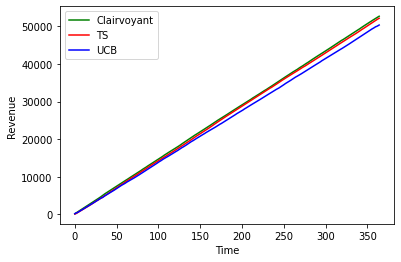

In [8]:
import matplotlib.pyplot as plt
plt.plot(np.cumsum(clairvoyant_per_class_per_day), color='green', label='Clairvoyant')
plt.plot(np.cumsum(ts_rewards_per_class_per_day), color='red', label='TS')
plt.plot(np.cumsum(u_rewards_per_class_per_day), color='blue', label='UCB')
#plt.plot(np.cumsum(c_expected_per_day), color='black', label='Expected')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Revenue')

Text(0, 0.5, 'Regret')

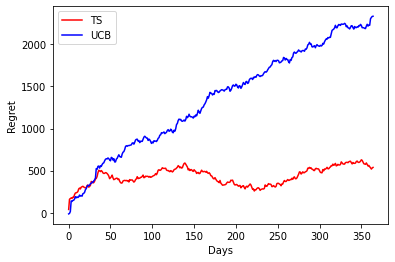

In [9]:
plt.plot(np.cumsum(np.array(clairvoyant_per_class_per_day) - np.array(ts_rewards_per_class_per_day)), color='red', label='TS')
plt.plot(np.cumsum(np.array(clairvoyant_per_class_per_day) - np.array(u_rewards_per_class_per_day)), color='blue', label='UCB')

plt.legend()
plt.xlabel('Days')
plt.ylabel('Regret')

In [10]:
#plt.plot(np.cumsum(np.array(c_expected_per_day) - np.array(ts_rewards_per_class_per_day)), color='red', label='TS')
#plt.plot(np.cumsum(np.array(c_expected_per_day) - np.array(u_rewards_per_class_per_day)), color='blue', label='UCB')

#plt.legend()
#plt.xlabel('Days')
#plt.ylabel('Regret')

In [11]:
prices_selected_ucb

[(120.0, 116),
 (80.0, 80),
 (160.0, 91),
 (240.0, 109),
 (200.0, 64),
 (120.0, 81),
 (120.0, 118),
 (120.0, 54),
 (80.0, 95),
 (120.0, 90),
 (200.0, 88),
 (120.0, 89),
 (120.0, 85),
 (120.0, 72),
 (160.0, 82),
 (120.0, 114),
 (120.0, 85),
 (120.0, 93),
 (120.0, 88),
 (80.0, 100),
 (120.0, 94),
 (120.0, 104),
 (120.0, 95),
 (120.0, 96),
 (120.0, 108),
 (120.0, 81),
 (120.0, 79),
 (120.0, 107),
 (120.0, 128),
 (120.0, 97),
 (120.0, 107),
 (120.0, 116),
 (160.0, 102),
 (240.0, 94),
 (80.0, 105),
 (120.0, 85),
 (120.0, 107),
 (120.0, 92),
 (120.0, 123),
 (120.0, 84),
 (200.0, 81),
 (120.0, 68),
 (120.0, 87),
 (120.0, 78),
 (120.0, 77),
 (120.0, 91),
 (120.0, 114),
 (120.0, 128),
 (120.0, 93),
 (120.0, 112),
 (120.0, 101),
 (120.0, 69),
 (120.0, 104),
 (120.0, 131),
 (120.0, 113),
 (120.0, 95),
 (120.0, 113),
 (120.0, 102),
 (120.0, 97),
 (120.0, 97),
 (120.0, 90),
 (80.0, 55),
 (120.0, 109),
 (120.0, 84),
 (120.0, 92),
 (120.0, 72),
 (120.0, 84),
 (120.0, 72),
 (120.0, 75),
 (120.0, 106),

In [12]:
from scipy import stats
stats.mode(prices_selected_ts)

ModeResult(mode=array([80.]), count=array([315]))